## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

---

## Workbook Setup and Data Preparation

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

#### Load Data

In [3]:
df_all = pd.read_csv('./data/dialog_norm.csv')
df_all.columns

Index(['Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

In [4]:
df_all.head(3)

,Instruction_id,category,selfdialog_norm
0,restaurant-table-2,0,hi im looking book table korean fod ok area thinking somewhere southern nyc maybe east village ok great theres thursday kitchen great reviews thats great need table tonight pm people dont want sit bar anywhere else fine dont availability pm times available yikes cant times ok second choice let check ok lets try boka free people yes great lets book ok great requests thats book great use account open yes please great get confirmation phone soon
1,movie-tickets-1,1,hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie
2,movie-tickets-3,2,want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir thank welcome


#### Remove NaN rows

In [5]:
print(df_all.shape)
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)
print(df_all.shape)

(7708, 3)
(7705, 3)


#### Get a Sample of records.

In [6]:
cat_id_df = df_all[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
cat_count = len(cat_id_df)
sample_size = 2000
sample_per_cat = sample_size//cat_count
print('sample_size: ', sample_size, 'sample_per_cat: ', sample_per_cat)

sample_size:  2000 sample_per_cat:  142


In [7]:
# Function to Get balanced Sample - Get a bit more than needed then down sample
def sampling_k_elements(group, k=sample_per_cat + 20):
    if len(group) < k:
        return group
    return group.sample(k, random_state=5)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to sample_size
corpus_df = corpus_df.sample(n=sample_size, random_state=3)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    155
coffee-ordering-1     154
coffee-ordering-2     157
movie-finder           51
movie-tickets-1       157
movie-tickets-2       152
movie-tickets-3       153
pizza-ordering-1      157
pizza-ordering-2      155
restaurant-table-1    155
restaurant-table-2    153
restaurant-table-3     93
uber-lyft-1           156
uber-lyft-2           152
dtype: int64


#### Generate Corpus List

In [8]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm)

print(len(doc_lst))
doc_lst[1:5]

2000


['would like place order type pie would like would like plan cheese pizza would like toppings cheese pizza would like add order breadstick wings order much breadsticks breadsticks extra would like add order yes ill take order breadsticks sauce yes okay total comes would like delivered ill come pick okay give us minutes actually ready minutes sure bit drive yea still work ill come pick work okay ready minutes thank welcome see half hour',
 'hi able request lyft sure right sephora powell street awesome going university california berkeley kind car would like lets lyft shared ready go request later time please ok lyft shared sephora powell street uc berkeley correct yes total ok sounds great want pay card gift credit file lets gift credit ok ive requested lyft shared driver minutes receipt pop app phone yes also notified driver close arrive thank youre welcome bye',
 'hey need schedule appointment intelligent auto solutions okay car calling dodge caravan okay problem really loud rattling 

#### Split Data into Train and Test Sets

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['category'], test_size=0.25, random_state = 0)

#### Build Vocabulary

In [10]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in X_train]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 7276
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('want', 6), ('pm', 7), ('order', 8), ('tickets', 9), ('thank', 10)]


### Bag of Words Feature Extraction

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(X_train, y_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 5, 3, ..., 0, 0, 0],
       [0, 6, 4, ..., 0, 0, 0],
       ...,
       [0, 3, 3, ..., 0, 0, 0],
       [0, 9, 9, ..., 0, 0, 1],
       [0, 0, 2, ..., 0, 0, 0]], dtype=int64)

In [12]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,okay,ok,yes,want,pm,order,tickets,thank,please,time,one,need,...,marker,smooth,evenining,boma,tusker,fireworks,sees,numberyour,celebrants,sing,mohegan,curls,hire,wrapped,loewe
0,0,1,1,4,0,0,2,0,1,0,0,2,0,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,5,3,0,0,1,2,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,6,4,0,1,1,1,7,0,6,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,4,0,1,0,2,0,2,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,8,4,0,6,1,2,3,3,0,1,3,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,1,0,5,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1496,0,0,0,0,6,1,0,2,1,4,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1497,0,3,3,1,2,2,0,0,5,0,0,4,0,2,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1498,0,9,9,1,1,1,1,9,0,2,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
# Get BOW features
X_train_bow = cv_matrix #cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(1500, 7276)
(500, 7276)
(500,)


#### Define Model Builder Function

In [14]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

class Result_Metrics:
    def __init__(self, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()
    precision = metrics.precision_score(labels_test, pred, average='weighted')
    recall = metrics.recall_score(labels_test, pred, average='weighted')
    
    rm = Result_Metrics(pred, cm, report, f1, accuracy, precision, recall)

    return rm

### Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [15]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
rm_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [16]:

def Save_Benchmark(descr, feat_type, b_metrics, reset_rb, reset_rb_all):
    global rows_benchmarks
    global rows_benchmarks_all
    global df_benchmarks
    global df_benchmarks_all
    if (reset_rb):
        rows_benchmarks = []

    if (reset_rb_all):
        rows_benchmarks_all = []
    rows_benchmarks.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    rows_benchmarks_all.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])
    df_benchmarks_all = pd.DataFrame(rows_benchmarks_all, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])


In [17]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Baseline", "BOW", rm_nb_bow, True, True)
#df_benchmarks

In [18]:
from sklearn.metrics import confusion_matrix
#rm_nb_bow.cm

In [19]:
from sklearn import metrics
#print("Label" + rm_nb_bow.report)

### Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Functions

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

class Result_Metrics_selected:
    def __init__(self, x_train_sel, x_test_sel, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.x_train_sel = x_train_sel
        self.x_test_sel = x_test_sel
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler):
    x_train_scaled = scaler.fit_transform(features_train, labels_train)
    x_test_scaled = scaler.transform(features_test)
    return x_train_scaled, x_test_scaled

def Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test):
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(features_train, labels_train)
    chi_support = chi_selector.get_support()    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    return X_train_chi, X_test_chi

def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test)
    x_train_scaled, x_test_scaled = Get_Scaled_Features(X_train_chi, labels_train, X_test_chi, labels_test, scaler)
    rm_chi = Build_Model(model, x_train_scaled, labels_train, x_test_scaled, labels_test)
    return rm_chi

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]

    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()
    precision_chi = metrics.precision_score(labels_test, predict_chi, average='weighted')
    recall_chi = metrics.recall_score(labels_test, predict_chi, average='weighted')
    
    rm_chi = Result_Metrics_selected(X_train_chi, X_test_chi, predict_chi, cm_chi, report_chi, f1_chi, accuracy_chi, precision_chi, recall_chi)

    return rm_chi

#### Iterate through number of features and get benchmark results

In [21]:
a = 100
tot = X_train_bow.shape[1]
b = 100 * (tot//100)
c = 100
print(a, b, c)

100 7200 100


In [22]:
rows = []

scaler_min_max = MinMaxScaler()
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

In [23]:
#acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [24]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

1250 1350 1


#### Get a more fine-grained look at the optimal number of features region

In [25]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [26]:
#acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [27]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

1300


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [28]:
model_nb_bow_opt = MultinomialNB()
rm_chi_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)

In [29]:
#print(rm_chi_opt_bow.cm)

In [30]:
#print("Label" + rm_chi_opt_bow.report)

In [31]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BOW", rm_chi_opt_bow, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.7106067,0.7120000,0.6984593,0.7120000
1,BOW Naive Bayes Optimal Features Selected: 1300,BOW,0.7936794,0.7780000,0.7771803,0.7780000


---

## 1. Benchmark Comparison

### Benchmark the following four models: Logistic Regression (Multinomial) Naive Bayes Linear Support Vector Machine Random Forest

#### Baseline Features

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

model_ids = ['RF', 'SVC', 'NB','LR']
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=500),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model, model_id in zip(models, model_ids):
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_bow, y_train, scoring='f1_weighted', cv=CV)
    #precisions = cross_val_score(model, X_train_bow, y_train, scoring='precision_weighted', cv=CV)
    #recalls = cross_val_score(model, X_train_bow, y_train, scoring='recall_weighted', cv=CV)
    
    for i in range(0, 9, 1):
        entries.append((model_id, model_name, 'baseline', 'default', '', f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])       

#### Optimised Features

In [33]:

models = [
    #RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    #LogisticRegression(random_state=0, max_iter=500),
    LogisticRegression()
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
#entries = []

for model, model_id in zip(models, model_ids):
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='f1_weighted', cv=CV)
    #precisions = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='precision_weighted', cv=CV)
    #recalls = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='recall_weighted', cv=CV)

    for i in range(0, 9, 1):
        entries.append((model_id, model_name, 'optimized', 'default', '', f1_scores[i]))
        #entries.append((model_name, 'optimized', precisions[i], recalls[i], f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['Model_Id','Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])        

In [34]:
models_df = cv_df.groupby(['Model_Id', 'Model','Features', 'Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params               
LR       LogisticRegression     baseline  default                      0.6666673
                                optimized default                      0.6705171
NB       MultinomialNB          baseline  default                      0.6701002
                                optimized default                      0.7215813
RF       RandomForestClassifier baseline  default                      0.4994976
                                optimized default                      0.6616538
SVC      LinearSVC              baseline  default                      0.6490279
                                optimized default                      0.6444873

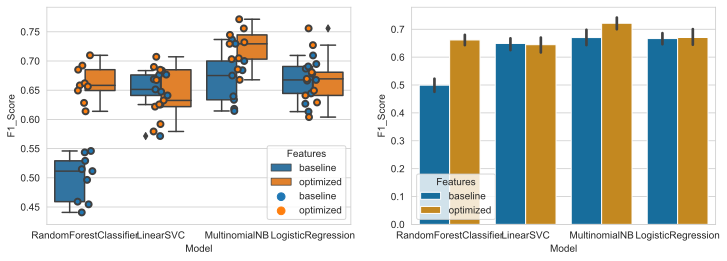

In [35]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)
sns.boxplot(x='Model', y='F1_Score', data=cv_df, hue='Features', ax=ax1);
sns.stripplot(x='Model', y='F1_Score', data=cv_df, hue='Features', size=6, jitter=True, edgecolor="gray", linewidth=2, ax=ax1);
sns.barplot(y='F1_Score', x='Model', data=cv_df, palette="colorblind", hue='Features', ax=ax2);


## Optimize the Hyperparameters Using Grid Search

In [36]:
from sklearn.model_selection import GridSearchCV

class Estimator_Parameters:
    def __init__(self, estimator, parameters, feat_type, x, y):
        self.estimator = estimator
        self.parameters = parameters
        self.feat_type = feat_type
        self.x = x
        self.y = y

def Get_Best_Parameters(est_param):
    grid_search = GridSearchCV(estimator = est_param.estimator,
                            param_grid = est_param.parameters,
                            scoring = 'f1_weighted',
                            cv= 10,
                            n_jobs = -1)
    grid_search = grid_search.fit(est_param.x, est_param.y)
    return grid_search.best_score_, grid_search.best_params_

In [37]:
# Get Model Parameter Details
#RandomForestClassifier?
#LinearSVC?
#MultinomialNB?
#LogisticRegression?

In [38]:
from sklearn.model_selection import GridSearchCV

est_param_arr = [
    Estimator_Parameters(RandomForestClassifier(), [{'n_estimators': [50,100,150,200,250,300],'max_depth': [1, 2, 3,4,5], 'random_state': [0,1,2,3]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(LinearSVC(), [{'C': [1000, 1400, 1500, 1600],'loss': ['hinge', 'squared_hinge'], 'dual': [True, False], 'penalty': ['l1', 'l2'], 'max_iter': [1000, 1500, 2000]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(MultinomialNB(), [{'alpha': [0.1,0.2,0.3,0.4,0.42,0.44,0.46,0.48,0.5],'fit_prior': [True, False]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(LogisticRegression(), [{'C': [1,2,3], 'penalty': ['l1', 'l2', 'elasticnet', 'none'],'dual': [True, False], 'multi_class': ['auto', 'ovr', 'multinomial']}], "optimized", rm_chi_opt_bow.x_train_sel, y_train)
]

for est_param, model_id in : in zip(est_param_arr, model_ids):
    estimator_name = est_param.estimator.__class__.__name__
    best_accuracy, best_parameters = Get_Best_Parameters(est_param)
    entries.append([model_id, estimator_name, est_param.feat_type, 'tuned', str(best_parameters), best_accuracy])
    print(estimator_name, best_accuracy, best_parameters, est_param.feat_type)

SyntaxError: invalid syntax (<ipython-input-38-b4dbcfe7caed>, line 10)

In [39]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id', 'Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params               
LR       LogisticRegression     baseline  default                      0.6666673
                                optimized default                      0.6705171
NB       MultinomialNB          baseline  default                      0.6701002
                                optimized default                      0.7215813
RF       RandomForestClassifier baseline  default                      0.4994976
                                optimized default                      0.6616538
SVC      LinearSVC              baseline  default                      0.6490279
                                optimized default                      0.6444873

## 2. a. Learning Curves: Training/ Testing Errors - Optimized Hyperarameters

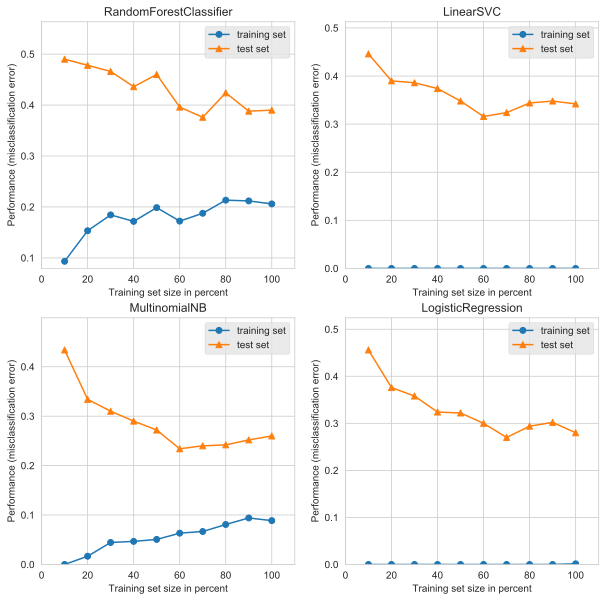

In [40]:
from mlxtend.plotting import plot_learning_curves
import itertools
import matplotlib.gridspec as gridspec

models = [
    RandomForestClassifier(n_estimators=300, max_depth=5, random_state=1),
    LinearSVC(C=1000, dual=False, loss='squared_hinge', max_iter=1000, penalty='l2'),
    MultinomialNB(alpha=0.1, fit_prior=True),
    LogisticRegression(C=3, dual=False, multi_class='ovr', penalty='l2'),
]

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, grd in zip(models, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, print_model=False, style='ggplot')
    plt.title(model_name)
         
plt.show()

---

## 2. b. Learning Curves: Scores, Performance and Scalability - Optimized Hyperarameters

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [42]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

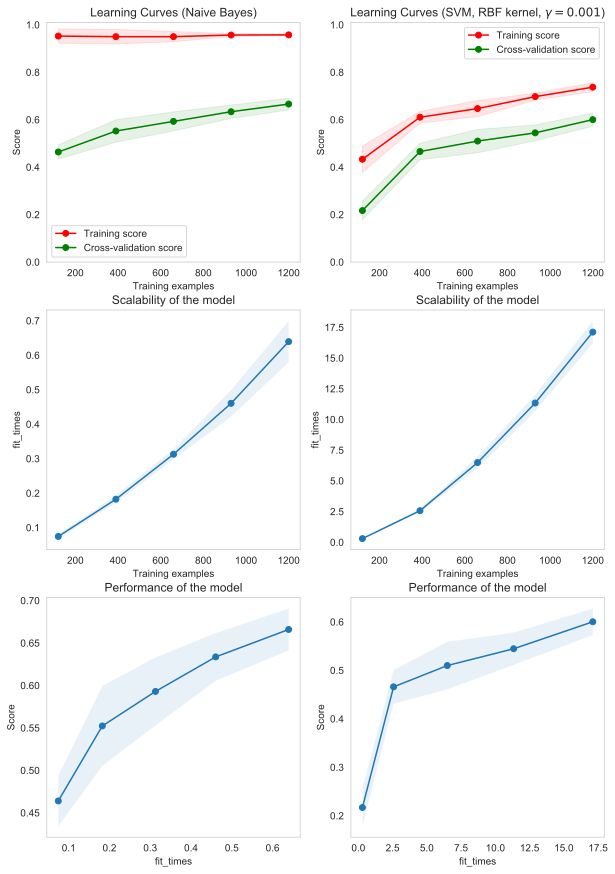

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = X_train_bow, y_train

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = MultinomialNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

---

## 3. Ensemble Learning

#### Initialize Models with optimized hyperparameters

In [44]:
clf1 = RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators = 250, random_state = 1)
clf2 = LinearSVC(C=1000, dual=False, loss='squared_hinge', max_iter=2000, penalty='l1')
clf3 = MultinomialNB(alpha=0.1, fit_prior=True)
clf4 = LogisticRegression(C=3, dual=False, multi_class='ovr', penalty='l2')

## Bagging

In [45]:
from sklearn.ensemble import BaggingClassifier

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8)
bagging3 = BaggingClassifier(base_estimator=clf3, n_estimators=10, max_samples=0.8)
bagging4 = BaggingClassifier(base_estimator=clf4, n_estimators=10, max_samples=0.8)

## Learning Curves for Bagged Models

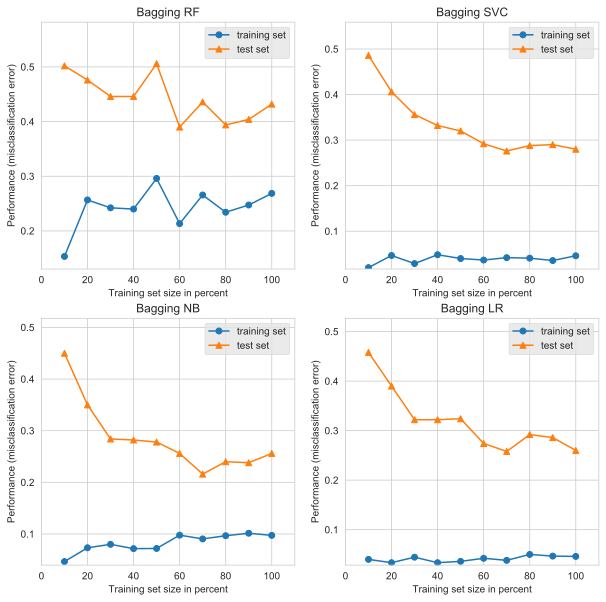

In [46]:
from mlxtend.plotting import plot_learning_curves

models = [
    bagging1, bagging2, bagging3, bagging4
]
labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, label, grd in zip(models, labels, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, print_model=False, style='ggplot')
    plt.title(label)
         
plt.show()

## Bagging Scores Varied by Ensemble Size

---

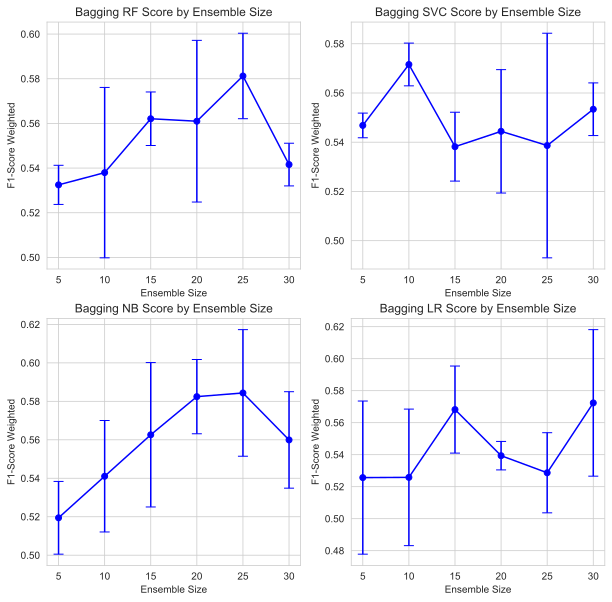

In [47]:
clf_list = [clf1, clf2, clf3, clf4]
labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, labels, grid):  
    num_est = map(int, np.linspace(5,30,6))
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    for n_est in num_est:    
        bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
        scores = cross_val_score(bg_clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())

    num_est = list(map(int, np.linspace(5,30,6)))
    ax = plt.subplot(gs[grd[0], grd[1]]) 

    (_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)
                                                                                         
    fig2 = plt.ylabel('F1-Score Weighted'); plt.xlabel('Ensemble Size'); plt.title(label + ' Score by Ensemble Size');
plt.show()

In [48]:
bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=30, max_samples=0.9)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.7)
bagging3 = BaggingClassifier(base_estimator=clf3, n_estimators=20, max_samples=0.8)
bagging4 = BaggingClassifier(base_estimator=clf4, n_estimators=15, max_samples=0.7)

In [49]:
from mlxtend.plotting import plot_decision_regions
import itertools
import matplotlib.gridspec as gridspec

labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']
clf_list = [bagging1, bagging2, bagging3, bagging4]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 4)
grid = itertools.product([0,1],repeat=4)

for clf, label, grd, model_id in zip(clf_list, labels, grid, model_ids):        
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
    entries.append([model_id, label, 'optimized', 'tuned', '', scores.mean()])
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.57 (+/- 0.01) [Bagging RF]
Accuracy: 0.68 (+/- 0.01) [Bagging SVC]
Accuracy: 0.72 (+/- 0.01) [Bagging NB]
Accuracy: 0.68 (+/- 0.01) [Bagging LR]


<Figure size 1000x800 with 0 Axes>

In [50]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id','Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params               
LR       Bagging LR             optimized tuned                        0.6793455
         LogisticRegression     baseline  default                      0.6666673
                                optimized default                      0.6705171
NB       Bagging NB             optimized tuned                        0.7208248
         MultinomialNB          baseline  default                      0.6701002
                                optimized default                      0.7215813
RF       Bagging RF             optimized tuned                        0.5747373
         RandomForestClassifier baseline  default                      0.4994976
                                optimized default                      0.6616538
SVC      Bagging SVC            optimized tuned                        0.6811592
         LinearSVC              baseline  default                      0.6490279
                                optimized default                      0.6444873

## Boosting

In [51]:
from sklearn.ensemble import AdaBoostClassifier

boosting1 = AdaBoostClassifier(base_estimator=clf1)
boosting2 = AdaBoostClassifier(base_estimator=clf2, algorithm='SAMME')
boosting3 = AdaBoostClassifier(base_estimator=clf3)
boosting4 = AdaBoostClassifier(base_estimator=clf4)

## Boosting Scores Varied by Ensemble Size

F1-Score Weighted: 0.56 (+/- 0.01) [AdaBoost RF]
F1-Score Weighted: 0.66 (+/- 0.03) [AdaBoost RF]
F1-Score Weighted: 0.65 (+/- 0.02) [AdaBoost RF]
F1-Score Weighted: 0.65 (+/- 0.01) [AdaBoost RF]
F1-Score Weighted: 0.64 (+/- 0.01) [AdaBoost RF]
F1-Score Weighted: 0.64 (+/- 0.02) [AdaBoost SVC]
F1-Score Weighted: 0.64 (+/- 0.02) [AdaBoost SVC]
F1-Score Weighted: 0.64 (+/- 0.02) [AdaBoost SVC]
F1-Score Weighted: 0.64 (+/- 0.02) [AdaBoost SVC]
F1-Score Weighted: 0.64 (+/- 0.02) [AdaBoost SVC]
F1-Score Weighted: 0.55 (+/- 0.02) [AdaBoost NB]
F1-Score Weighted: 0.40 (+/- 0.02) [AdaBoost NB]
F1-Score Weighted: 0.43 (+/- 0.01) [AdaBoost NB]
F1-Score Weighted: 0.48 (+/- 0.03) [AdaBoost NB]
F1-Score Weighted: 0.51 (+/- 0.01) [AdaBoost NB]
F1-Score Weighted: 0.64 (+/- 0.03) [AdaBoost LR]
F1-Score Weighted: 0.63 (+/- 0.01) [AdaBoost LR]
F1-Score Weighted: 0.60 (+/- 0.01) [AdaBoost LR]
F1-Score Weighted: 0.58 (+/- 0.01) [AdaBoost LR]
F1-Score Weighted: 0.58 (+/- 0.01) [AdaBoost LR]


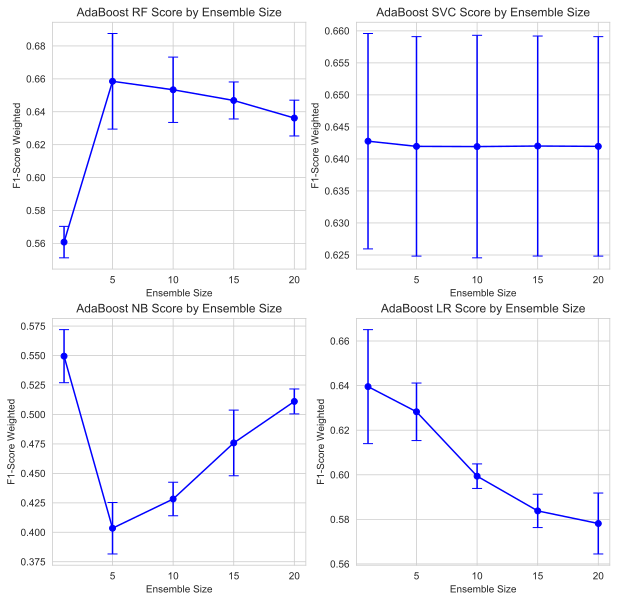

In [52]:
from sklearn.ensemble import AdaBoostClassifier

bst_list = [boosting1, boosting2, boosting3, boosting4]
labels = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for boosting, label, grd in zip(bst_list, labels, grid):  
    num_est = map(int, np.linspace(1,20,5))
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    for n_est in num_est:
        boosting.set_params(n_estimators=n_est)
        scores = cross_val_score(boosting, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())
        print("F1-Score Weighted: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    
    ax = plt.subplot(gs[grd[0], grd[1]]) 
    num_est = list(map(int, np.linspace(1,20,5)))
    (_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)                                                                                                                                
    fig2 = plt.ylabel('F1-Score Weighted'); plt.xlabel('Ensemble Size'); plt.title(label + ' Score by Ensemble Size');


In [53]:
plt.show()

## Learning Curves for Boosted Models

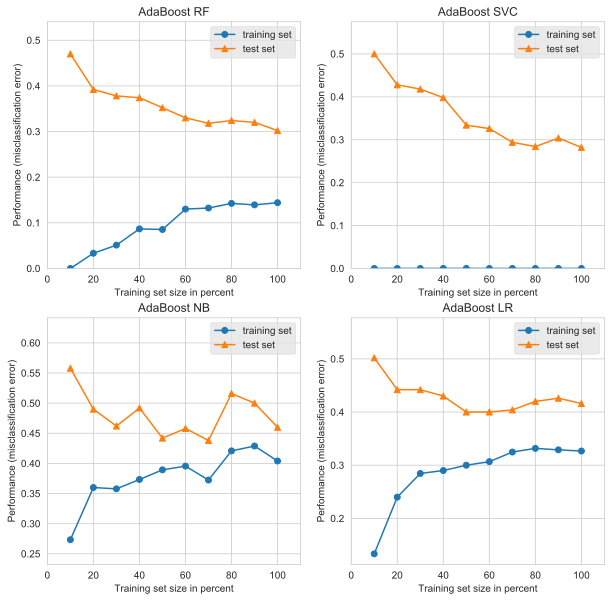

In [54]:
#plot Boosting learning curve
fig_bst = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for boosting, label, grd in zip(bst_list, labels, grid):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig_bst = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, boosting, print_model=False, style='ggplot')
    plt.title(label)
plt.show()

In [55]:
boosting1 = AdaBoostClassifier(base_estimator=clf1, n_estimators=10)
boosting2 = AdaBoostClassifier(base_estimator=clf2, n_estimators=3, algorithm='SAMME')
boosting3 = AdaBoostClassifier(base_estimator=clf3, n_estimators=1)
boosting4 = AdaBoostClassifier(base_estimator=clf4, n_estimators=2)
boost_list = [boosting1, boosting2, boosting3, boosting4]
labels_bst = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']

In [63]:
from sklearn.ensemble import AdaBoostClassifier

labels = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']
bst_list = [boosting1, boosting2, boosting3, boosting4]

for boosting, label, model_id in zip(bst_list, labels, model_ids):
    
    scores = cross_val_score(boosting, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
    entries.append([model_id, label, 'optimized', 'tuned', '', scores.mean()])
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.65 (+/- 0.02) [AdaBoost RF]
Accuracy: 0.64 (+/- 0.02) [AdaBoost SVC]
Accuracy: 0.55 (+/- 0.02) [AdaBoost NB]
Accuracy: 0.66 (+/- 0.03) [AdaBoost LR]


In [64]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id','Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id    Model                  Features  Hyper_Param Best_Params               
Boost_Stack Stacking Boosted LR    optimized tuned                        0.4653333
LR          AdaBoost LR            optimized tuned                        0.6580842
            Bagging LR             optimized tuned                        0.6793455
            LogisticRegression     baseline  default                      0.6666673
                                   optimized default                      0.6705171
NB          AdaBoost NB            optimized tuned                        0.5494779
            Bagging NB             optimized tuned                        0.7208248
            MultinomialNB          baseline  default                      0.6701002
                                   optimized default                      0.7215813
RF          AdaBoost RF            optimized tuned                        0.6496885
            Bagging RF             optimized tuned                        0.5747373
            RandomForestClassifier baseline  default                      0.4994976
                                   optimized default                      0.6616538
SVC         AdaBoost SVC           optimized tuned                        0.6419659
            Bagging SVC            optimized tuned                        0.6811592
            LinearSVC              baseline  default                      0.6490279
                                   optimized default                      0.6444873
Stack       Stacking LR            optimized tuned                        0.4766667

## Stacking

In [58]:
from mlxtend.classifier import StackingClassifier

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=clf4)

labels = ['Random Forest', 'LinearSVC', 'MultinomialNB', 'Stacking LR']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, labels, grid):
        
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    if (label == 'Stacking LR'):
        entries.append(['Stack', label, 'optimized', 'tuned', '', scores.mean()])
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.61 (+/- 0.02) [Random Forest]
Accuracy: 0.65 (+/- 0.02) [LinearSVC]
Accuracy: 0.75 (+/- 0.01) [MultinomialNB]
Accuracy: 0.48 (+/- 0.05) [Stacking LR]


<Figure size 1000x800 with 0 Axes>

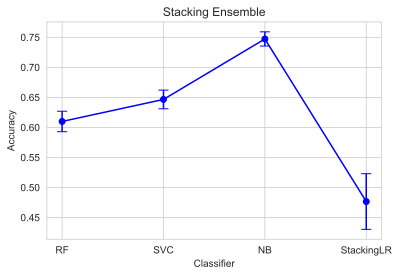

In [59]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['RF', 'SVC', 'NB', 'StackingLR'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

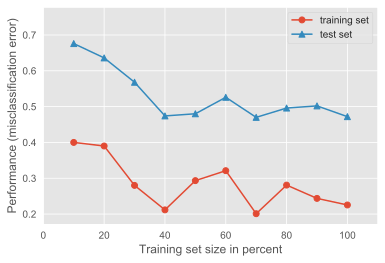

In [60]:
#plot Stacking learning curve
plt.figure()
plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, sclf, print_model=False, style='ggplot')
plt.show()

In [61]:
from mlxtend.classifier import StackingClassifier

sclf_bst = StackingClassifier(classifiers=[boosting1, boosting2, boosting3], meta_classifier=clf4)

labels = ['Boosted RF', 'Boosted SVC', 'Boosted NB', 'Stacking Boosted LR']
#clf_list = [clf1, clf2, clf3, sclf]
bst_list = [boosting1, boosting2, boosting3, sclf_bst]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(bst_list, labels, grid):
        
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    if (label == 'Stacking Boosted LR'):
        entries.append(['Boost_Stack', label, 'optimized', 'tuned', '', scores.mean()])
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.66 (+/- 0.01) [Boosted RF]
Accuracy: 0.64 (+/- 0.02) [Boosted SVC]
Accuracy: 0.60 (+/- 0.02) [Boosted NB]
Accuracy: 0.47 (+/- 0.04) [Stacking Boosted LR]


<Figure size 1000x800 with 0 Axes>

In [62]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id', 'Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id    Model                  Features  Hyper_Param Best_Params               
Boost_Stack Stacking Boosted LR    optimized tuned                        0.4653333
LR          Bagging LR             optimized tuned                        0.6793455
            LogisticRegression     baseline  default                      0.6666673
                                   optimized default                      0.6705171
NB          Bagging NB             optimized tuned                        0.7208248
            MultinomialNB          baseline  default                      0.6701002
                                   optimized default                      0.7215813
RF          Bagging RF             optimized tuned                        0.5747373
            RandomForestClassifier baseline  default                      0.4994976
                                   optimized default                      0.6616538
SVC         Bagging SVC            optimized tuned                        0.6811592
            LinearSVC              baseline  default                      0.6490279
                                   optimized default                      0.6444873
Stack       Stacking LR            optimized tuned                        0.4766667

## Summary of Findings